<a href="https://colab.research.google.com/github/semaHbo/job-clustering-salary-prediction/blob/main/eda_veri_temizleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive   #google drivei baglama
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile    #csv dosyasini zipten cikarma

zip_path = '/content/drive/MyDrive/datasets/archive.zip'
extract_path = '/content/datasets/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os   #dosyanin icerigi

for file in os.listdir(extract_path):
    print(file)


ds_salaries.csv


In [ ]:
!pip install pyspark    #spark kurulumu ve oturumu

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("JobClusteringSalaryPrediction") \
    .getOrCreate()


In [ ]:
data_path = extract_path + 'ds_salaries.csv'      #dosyayi okuma
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- _c0: integer (nullable = true)
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)

+---+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|_c0|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---+---------+----------------+---------------+--------------------+------+---------------+-------------+-----------------

In [ ]:
df.printSchema()   #EDA baslangic   sutunlar ve veri tipleri
df.columns


root
 |-- _c0: integer (nullable = true)
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



['_c0',
 'work_year',
 'experience_level',
 'employment_type',
 'job_title',
 'salary',
 'salary_currency',
 'salary_in_usd',
 'employee_residence',
 'remote_ratio',
 'company_location',
 'company_size']

In [ ]:
df.show(10, truncate=False)  #ilk 10 satir


+---+---------+----------------+---------------+--------------------------+--------+---------------+-------------+------------------+------------+----------------+------------+
|_c0|work_year|experience_level|employment_type|job_title                 |salary  |salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---+---------+----------------+---------------+--------------------------+--------+---------------+-------------+------------------+------------+----------------+------------+
|0  |2020     |MI              |FT             |Data Scientist            |70000   |EUR            |79833        |DE                |0           |DE              |L           |
|1  |2020     |SE              |FT             |Machine Learning Scientist|260000  |USD            |260000       |JP                |0           |JP              |S           |
|2  |2020     |SE              |FT             |Big Data Engineer         |85000   |GBP            |109024       |G

In [ ]:
from pyspark.sql.functions import col, isnan, when, count   #eksik degerler

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|_c0|work_year|experience_level|employment_type|job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|  0|        0|               0|              0|        0|     0|              0|            0|                 0|           0|               0|           0|
+---+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+



In [ ]:
df.select("salary", "salary_in_usd", "remote_ratio").describe().show()  #sayisal sutunlar


+-------+-----------------+------------------+------------------+
|summary|           salary|     salary_in_usd|      remote_ratio|
+-------+-----------------+------------------+------------------+
|  count|              607|               607|               607|
|   mean|324000.0626029654|112297.86985172982| 70.92257001647447|
| stddev| 1544357.48663585| 70957.25941139567|40.709130040221204|
|    min|             4000|              2859|                 0|
|    max|         30400000|            600000|               100|
+-------+-----------------+------------------+------------------+



In [ ]:
#kategorik degiskenler
df.select("experience_level").groupBy("experience_level").count().show()
df.select("employment_type").groupBy("employment_type").count().show()
df.select("job_title").groupBy("job_title").count().orderBy("count", ascending=False).show(10, truncate=False)
df.select("company_size").groupBy("company_size").count().show()


+----------------+-----+
|experience_level|count|
+----------------+-----+
|              EX|   26|
|              MI|  213|
|              EN|   88|
|              SE|  280|
+----------------+-----+

+---------------+-----+
|employment_type|count|
+---------------+-----+
|             FT|  588|
|             PT|   10|
|             CT|    5|
|             FL|    4|
+---------------+-----+

+--------------------------+-----+
|job_title                 |count|
+--------------------------+-----+
|Data Scientist            |143  |
|Data Engineer             |132  |
|Data Analyst              |97   |
|Machine Learning Engineer |41   |
|Research Scientist        |16   |
|Data Science Manager      |12   |
|Data Architect            |11   |
|Machine Learning Scientist|8    |
|Big Data Engineer         |8    |
|Director of Data Science  |7    |
+--------------------------+-----+
only showing top 10 rows

+------------+-----+
|company_size|count|
+------------+-----+
|           L|  198|
|     

In [ ]:
#sutun isimlerini turkcelestirme
df = df.withColumnRenamed("work_year", "Yil") \
       .withColumnRenamed("experience_level", "Deneyim_Seviyesi") \
       .withColumnRenamed("employment_type", "Calisma_Tipi") \
       .withColumnRenamed("job_title", "Pozisyon") \
       .withColumnRenamed("salary", "Maas_Orijinal") \
       .withColumnRenamed("salary_currency", "Para_Birimi") \
       .withColumnRenamed("salary_in_usd", "Maas_USD") \
       .withColumnRenamed("employee_residence", "Calisan_Ulke") \
       .withColumnRenamed("remote_ratio", "Uzaktan_Calisma_Orani") \
       .withColumnRenamed("company_location", "Sirket_Ulke") \
       .withColumnRenamed("company_size", "Sirket_Buyuklugu")


In [ ]:
#deneyim seviyelerini turkcelestirme
from pyspark.sql.functions import when

df = df.withColumn("Deneyim_Seviyesi",
          when(df["Deneyim_Seviyesi"] == "EN", "Yeni Baslayan")
         .when(df["Deneyim_Seviyesi"] == "MI", "Orta Duzey")
         .when(df["Deneyim_Seviyesi"] == "SE", "Kidemli")
         .when(df["Deneyim_Seviyesi"] == "EX", "Yonetici")
         .otherwise(df["Deneyim_Seviyesi"]))


In [ ]:
#calisma tipi degerlerini turkcelestirme
df = df.withColumn("Calisma_Tipi",
          when(df["Calisma_Tipi"] == "FT", "Tam Zamanli")
         .when(df["Calisma_Tipi"] == "PT", "Yari Zamanli")
         .when(df["Calisma_Tipi"] == "CT", "Sozlesmeli")
         .when(df["Calisma_Tipi"] == "FL", "Serbest")
         .otherwise(df["Calisma_Tipi"]))


In [ ]:
#sirket tipi degerlerini turkcelestirme
df = df.withColumn("Sirket_Buyuklugu",
          when(df["Sirket_Buyuklugu"] == "S", "Kucuk")
         .when(df["Sirket_Buyuklugu"] == "M", "Orta")
         .when(df["Sirket_Buyuklugu"] == "L", "Buyuk")
         .otherwise(df["Sirket_Buyuklugu"]))


In [ ]:
#gereksiz sutunu silme
df = df.drop("_c0")


In [ ]:
df.show(10, truncate=False)  #guncellenmis veri seti


+----+----------------+------------+--------------------------+-------------+-----------+--------+------------+---------------------+-----------+----------------+
|Yil |Deneyim_Seviyesi|Calisma_Tipi|Pozisyon                  |Maas_Orijinal|Para_Birimi|Maas_USD|Calisan_Ulke|Uzaktan_Calisma_Orani|Sirket_Ulke|Sirket_Buyuklugu|
+----+----------------+------------+--------------------------+-------------+-----------+--------+------------+---------------------+-----------+----------------+
|2020|Orta Duzey      |Tam Zamanli |Data Scientist            |70000        |EUR        |79833   |DE          |0                    |DE         |Buyuk           |
|2020|Kidemli         |Tam Zamanli |Machine Learning Scientist|260000       |USD        |260000  |JP          |0                    |JP         |Kucuk           |
|2020|Kidemli         |Tam Zamanli |Big Data Engineer         |85000        |GBP        |109024  |GB          |50                   |GB         |Orta            |
|2020|Orta Duzey      

In [ ]:
# 500.000 USD üzerindeki maaşları filtrele
df = df.filter(df["Maas_USD"] <= 500000)

# Sonuçları kontrol et
from pyspark.sql.functions import max, min, avg
df.select(min("Maas_USD"), max("Maas_USD"), avg("Maas_USD")).show()


+-------------+-------------+------------------+
|min(Maas_USD)|max(Maas_USD)|     avg(Maas_USD)|
+-------------+-------------+------------------+
|         2859|       450000|111493.08085808581|
+-------------+-------------+------------------+



In [ ]:
pandas_df = df.select("Maas_USD").toPandas()


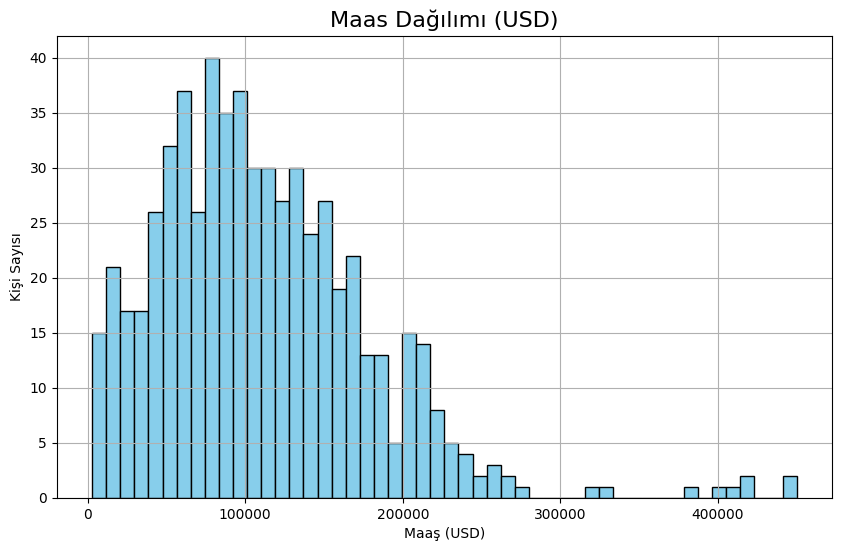

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(pandas_df["Maas_USD"], bins=50, color='skyblue', edgecolor='black')
plt.title("Maas Dağılımı (USD)", fontsize=16)
plt.xlabel("Maaş (USD)")
plt.ylabel("Kişi Sayısı")
plt.grid(True)
plt.show()
#maasin histogrami

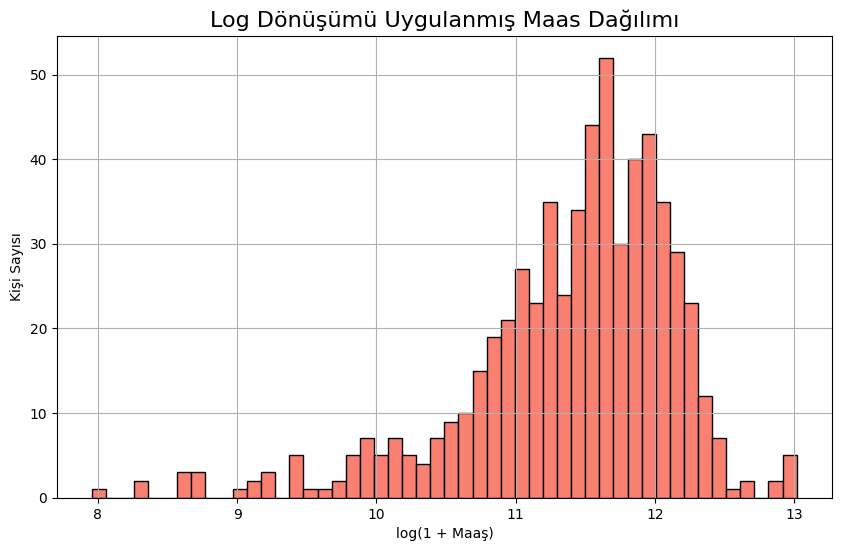

In [ ]:
import numpy as np

plt.figure(figsize=(10,6))
plt.hist(np.log1p(pandas_df["Maas_USD"]), bins=50, color='salmon', edgecolor='black')
plt.title("Log Dönüşümü Uygulanmış Maas Dağılımı", fontsize=16)
plt.xlabel("log(1 + Maaş)")
plt.ylabel("Kişi Sayısı")
plt.grid(True)
plt.show()


In [ ]:
from pyspark.sql.functions import log1p

df = df.withColumn("Log_Maas_USD", log1p(df["Maas_USD"]))


In [ ]:
#pozisyondaki kisi sayilari
df.groupBy("Pozisyon").count().orderBy("count", ascending=False).show(50, truncate=False)


+----------------------------------------+-----+
|Pozisyon                                |count|
+----------------------------------------+-----+
|Data Scientist                          |143  |
|Data Engineer                           |132  |
|Data Analyst                            |97   |
|Machine Learning Engineer               |41   |
|Research Scientist                      |16   |
|Data Science Manager                    |12   |
|Data Architect                          |11   |
|Machine Learning Scientist              |8    |
|Big Data Engineer                       |8    |
|Principal Data Scientist                |7    |
|AI Scientist                            |7    |
|Director of Data Science                |7    |
|Data Science Consultant                 |7    |
|Data Analytics Manager                  |7    |
|Lead Data Engineer                      |6    |
|ML Engineer                             |6    |
|Computer Vision Engineer                |6    |
|BI Data Analyst    

In [ ]:
#pozisyondaki deneyim seviyelerindeki kisi sayisi
df.groupBy("Pozisyon", "Deneyim_Seviyesi").count().orderBy("count", ascending=False).show(100, truncate=False)


+----------------------------------------+----------------+-----+
|Pozisyon                                |Deneyim_Seviyesi|count|
+----------------------------------------+----------------+-----+
|Data Engineer                           |Kidemli         |63   |
|Data Scientist                          |Kidemli         |61   |
|Data Scientist                          |Orta Duzey      |60   |
|Data Analyst                            |Kidemli         |54   |
|Data Engineer                           |Orta Duzey      |53   |
|Data Analyst                            |Orta Duzey      |29   |
|Data Scientist                          |Yeni Baslayan   |22   |
|Machine Learning Engineer               |Kidemli         |20   |
|Data Analyst                            |Yeni Baslayan   |12   |
|Machine Learning Engineer               |Orta Duzey      |12   |
|Data Engineer                           |Yeni Baslayan   |12   |
|Data Science Manager                    |Kidemli         |10   |
|Machine L

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
import random

# Eğitim ve test setlerini tutacak boş listeler
train_parts = []
test_parts = []

# Tüm benzersiz kombinasyonlar
combinations = df.select("Pozisyon", "Deneyim_Seviyesi").distinct().collect()

# Her kombinasyon için işlemler
for row in combinations:
    pozisyon = row["Pozisyon"]
    deneyim = row["Deneyim_Seviyesi"]

    # Kombinasyonu filtreleme  amac veri setini pozisyon deneyim oraninda bolmek
    subset = df.filter((col("Pozisyon") == pozisyon) & (col("Deneyim_Seviyesi") == deneyim))

    # Shuffle + randomSplit (%70 - %30)
    splitted = subset.randomSplit([0.7, 0.3], seed=random.randint(0, 10000))

    train_parts.append(splitted[0])
    test_parts.append(splitted[1])

# Parçaları birleştirme listelere ekleme
train_df = train_parts[0]
for part in train_parts[1:]:
    train_df = train_df.union(part)

test_df = test_parts[0]
for part in test_parts[1:]:
    test_df = test_df.union(part)

# Eğitim ve test boyutlarını gösterme
print("Eğitim veri sayısı:", train_df.count())
print("Test veri sayısı:", test_df.count())


Eğitim veri sayısı: 429
Test veri sayısı: 177


In [ ]:
# Spark veri çerçevelerini pandasa aktarma setleri grafiksellestirmek icin
import pandas as pd

df_pd = df.select("Maas_USD", "Pozisyon", "Deneyim_Seviyesi").toPandas()
df_pd["Set"] = "Tümü"

train_pd = train_df.select("Maas_USD", "Pozisyon", "Deneyim_Seviyesi").toPandas()
train_pd["Set"] = "Eğitim"

test_pd = test_df.select("Maas_USD", "Pozisyon", "Deneyim_Seviyesi").toPandas()
test_pd["Set"] = "Test"

# Hepsini birleştirme
combined_df = pd.concat([df_pd, train_pd, test_pd], ignore_index=True)


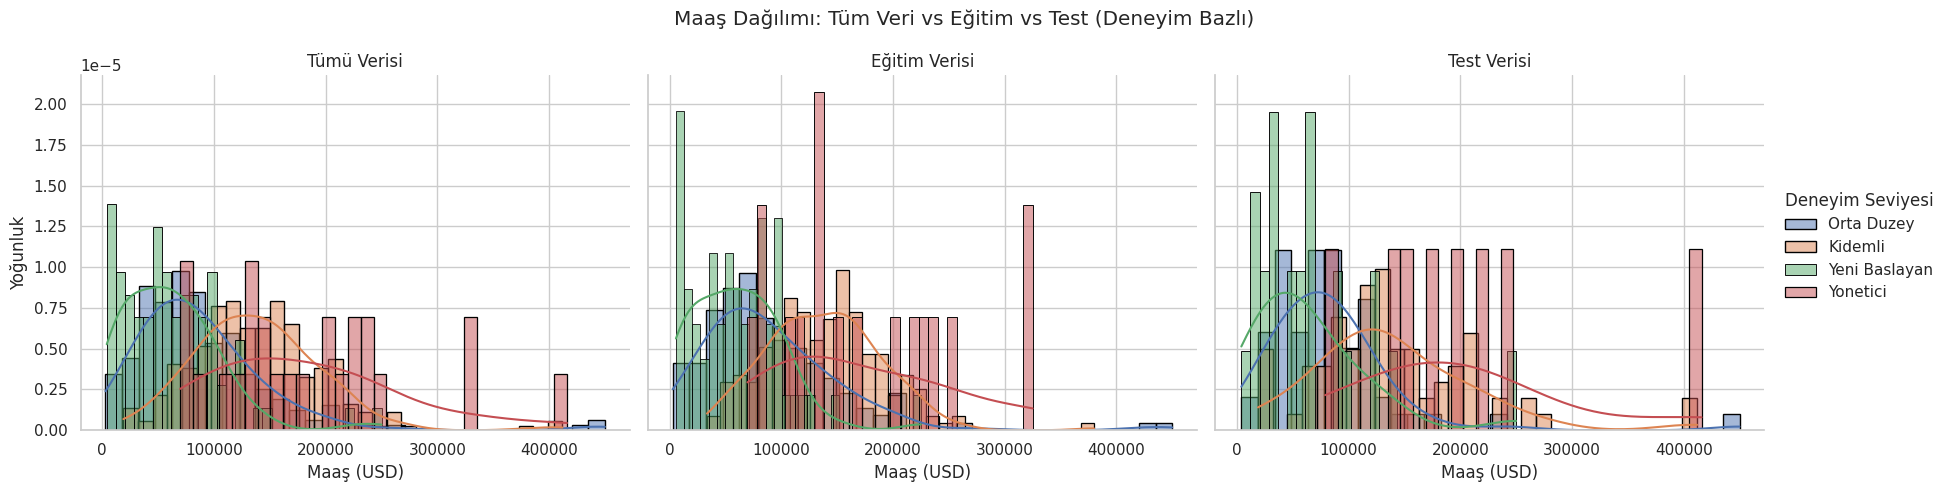

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# kde grafigi
sns.set(style="whitegrid")

# Grafik: Set'e göre sütun, Deneyim'e göre renk
g = sns.FacetGrid(combined_df, col="Set", hue="Deneyim_Seviyesi", height=5, aspect=1.2, col_order=["Tümü", "Eğitim", "Test"])
g.map(sns.histplot, "Maas_USD", kde=True, stat="density", bins=30, edgecolor="black", alpha=0.5)
g.add_legend(title="Deneyim Seviyesi")
g.set_titles("{col_name} Verisi")
g.set_axis_labels("Maaş (USD)", "Yoğunluk")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Maaş Dağılımı: Tüm Veri vs Eğitim vs Test (Deneyim Bazlı)")
plt.show()


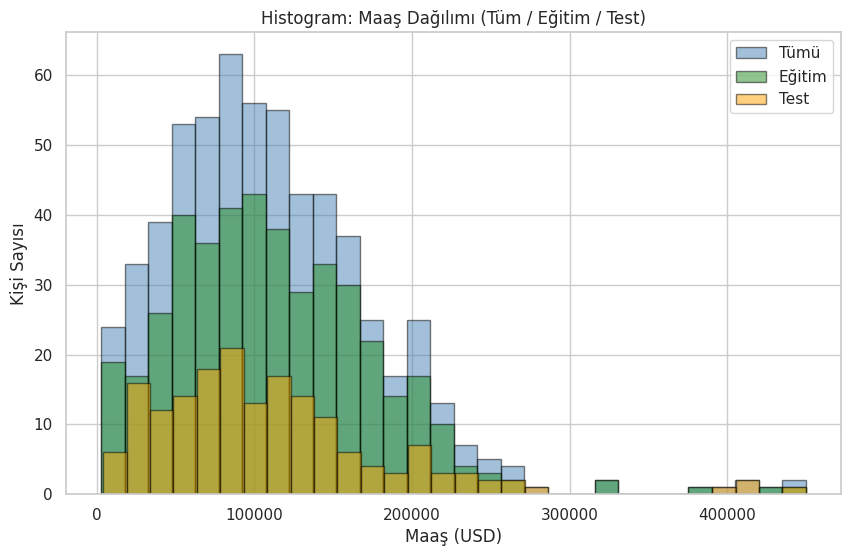

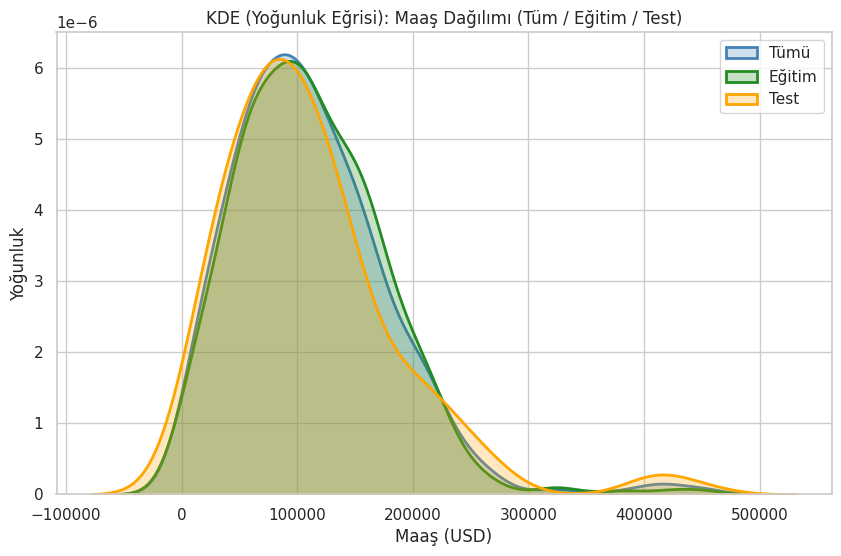

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Renkleri sabitle
renkler = {"Tümü": "steelblue", "Eğitim": "forestgreen", "Test": "orange"}

# 1️⃣ Histogram Grafiği
plt.figure(figsize=(10, 6))
for veri_seti in ["Tümü", "Eğitim", "Test"]:
    alt_df = combined_df[combined_df["Set"] == veri_seti]
    plt.hist(alt_df["Maas_USD"], bins=30, alpha=0.5, label=veri_seti, color=renkler[veri_seti], edgecolor="black")

plt.title("Histogram: Maaş Dağılımı (Tüm / Eğitim / Test)")
plt.xlabel("Maaş (USD)")
plt.ylabel("Kişi Sayısı")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ KDE Grafiği
plt.figure(figsize=(10, 6))
for veri_seti in ["Tümü", "Eğitim", "Test"]:
    alt_df = combined_df[combined_df["Set"] == veri_seti]
    sns.kdeplot(alt_df["Maas_USD"], label=veri_seti, fill=True, linewidth=2, color=renkler[veri_seti])

plt.title("KDE (Yoğunluk Eğrisi): Maaş Dağılımı (Tüm / Eğitim / Test)")
plt.xlabel("Maaş (USD)")
plt.ylabel("Yoğunluk")
plt.legend()
plt.grid(True)
plt.show()


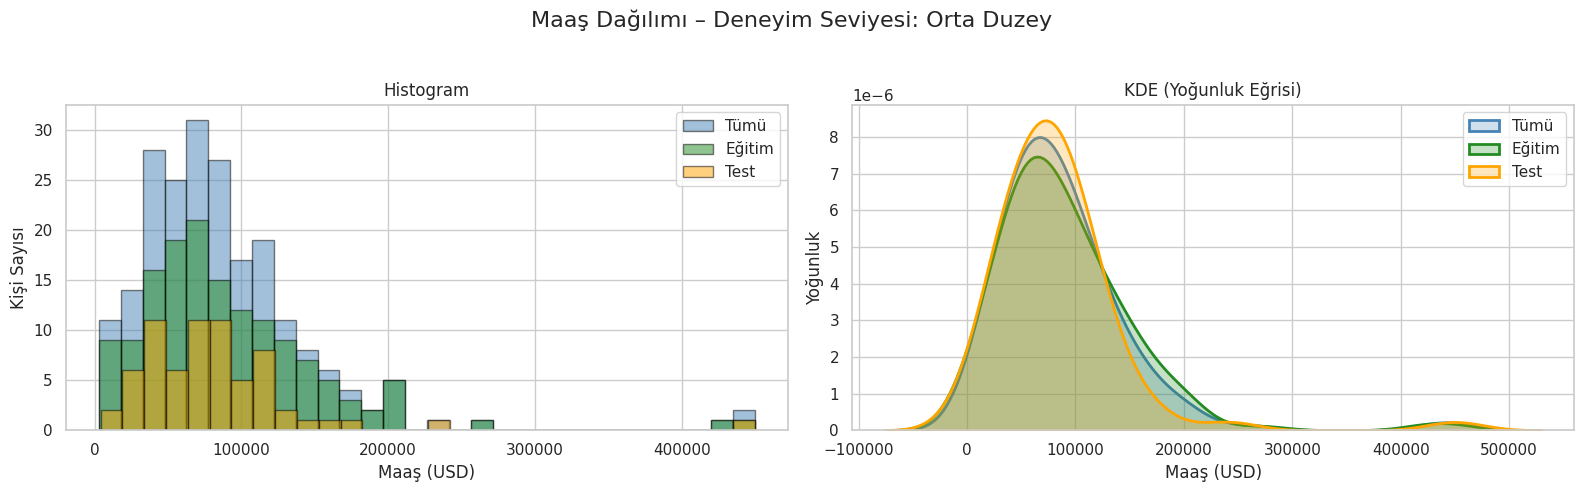

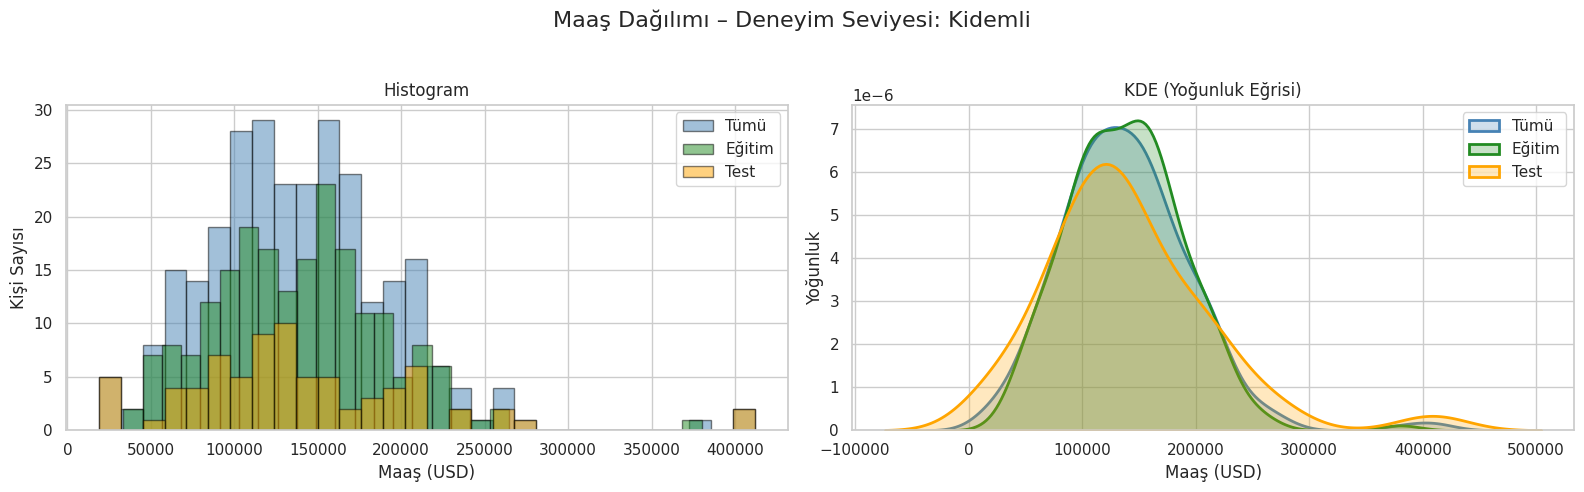

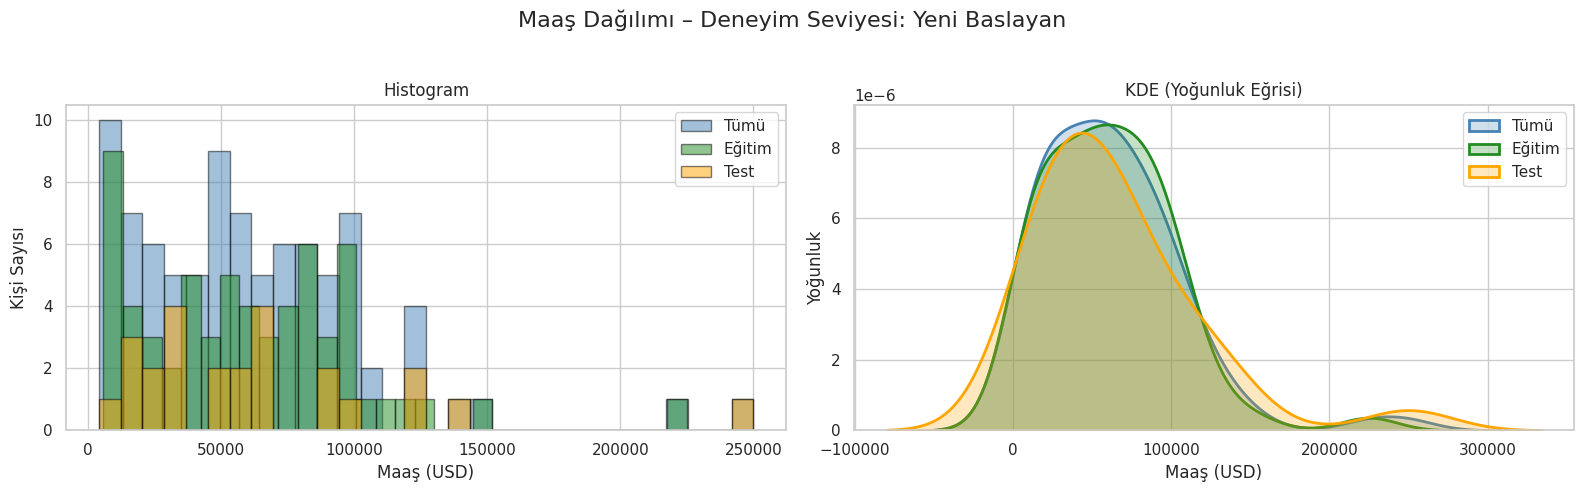

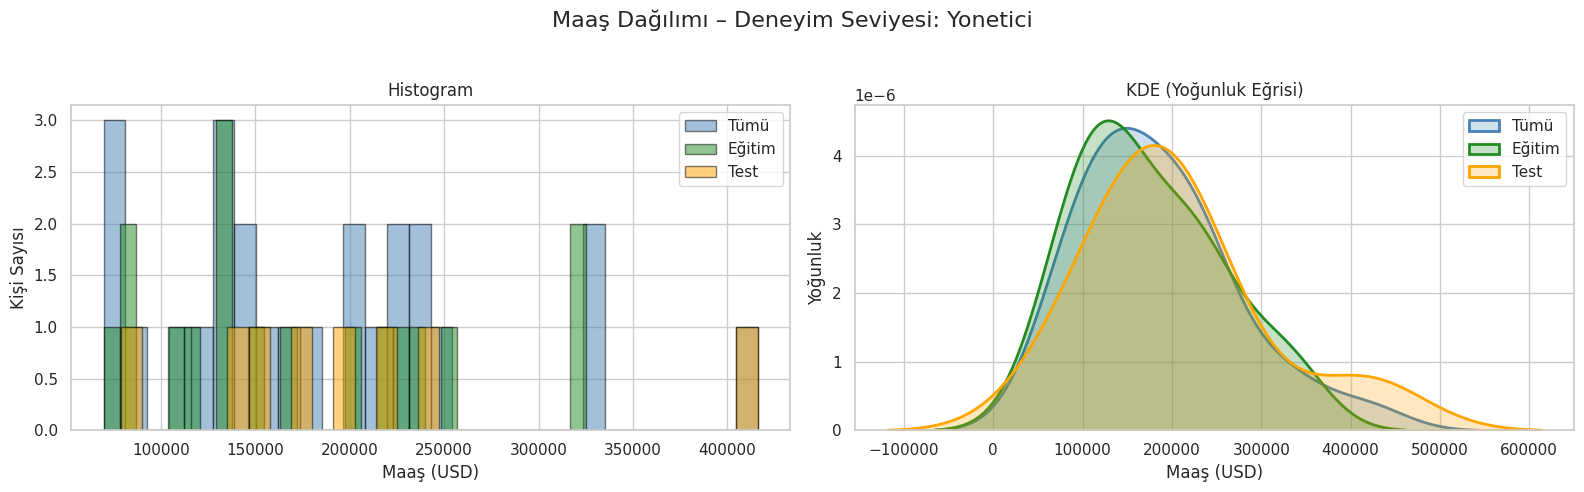

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
renkler = {"Tümü": "steelblue", "Eğitim": "forestgreen", "Test": "orange"}

# Benzersiz deneyim seviyelerini sırayla işleme
for seviye in combined_df["Deneyim_Seviyesi"].unique():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f"Maaş Dağılımı – Deneyim Seviyesi: {seviye}", fontsize=16)

    #histogram
    for set_tipi in ["Tümü", "Eğitim", "Test"]:
        alt_df = combined_df[(combined_df["Set"] == set_tipi) & (combined_df["Deneyim_Seviyesi"] == seviye)]
        axes[0].hist(alt_df["Maas_USD"], bins=30, alpha=0.5, label=set_tipi, color=renkler[set_tipi], edgecolor="black")
    axes[0].set_title("Histogram")
    axes[0].set_xlabel("Maaş (USD)")
    axes[0].set_ylabel("Kişi Sayısı")
    axes[0].legend()
    axes[0].grid(True)

    # KDE
    for set_tipi in ["Tümü", "Eğitim", "Test"]:
        alt_df = combined_df[(combined_df["Set"] == set_tipi) & (combined_df["Deneyim_Seviyesi"] == seviye)]
        if not alt_df.empty:
            sns.kdeplot(alt_df["Maas_USD"], label=set_tipi, fill=True, ax=axes[1], linewidth=2, color=renkler[set_tipi])
    axes[1].set_title("KDE (Yoğunluk Eğrisi)")
    axes[1].set_xlabel("Maaş (USD)")
    axes[1].set_ylabel("Yoğunluk")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


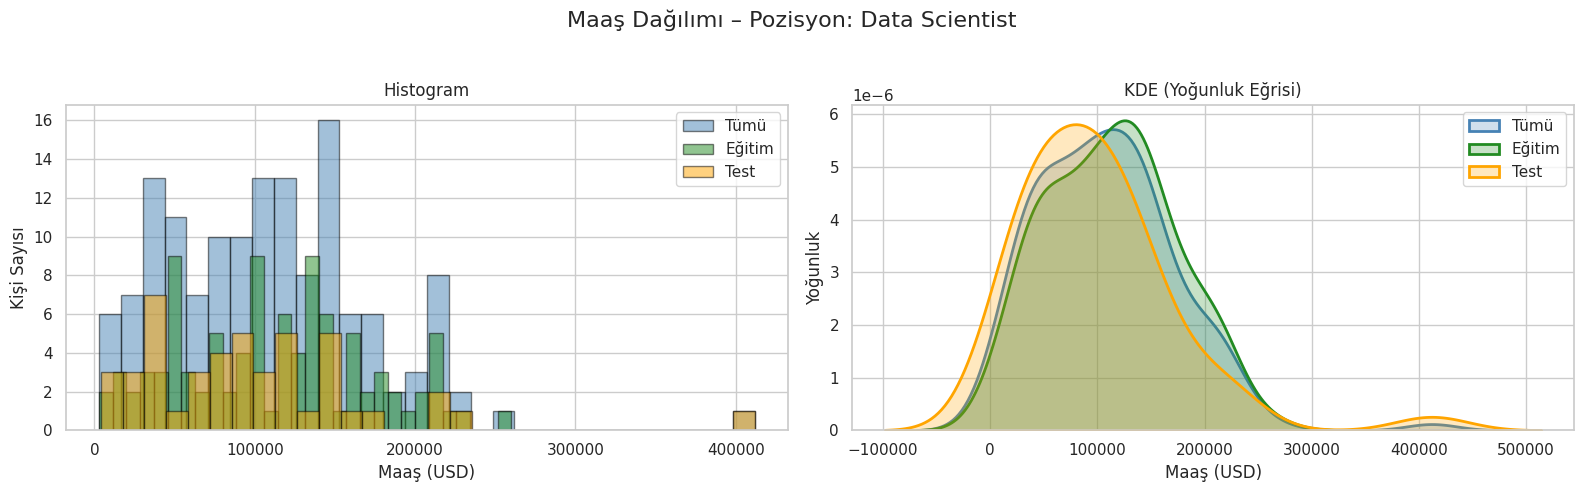

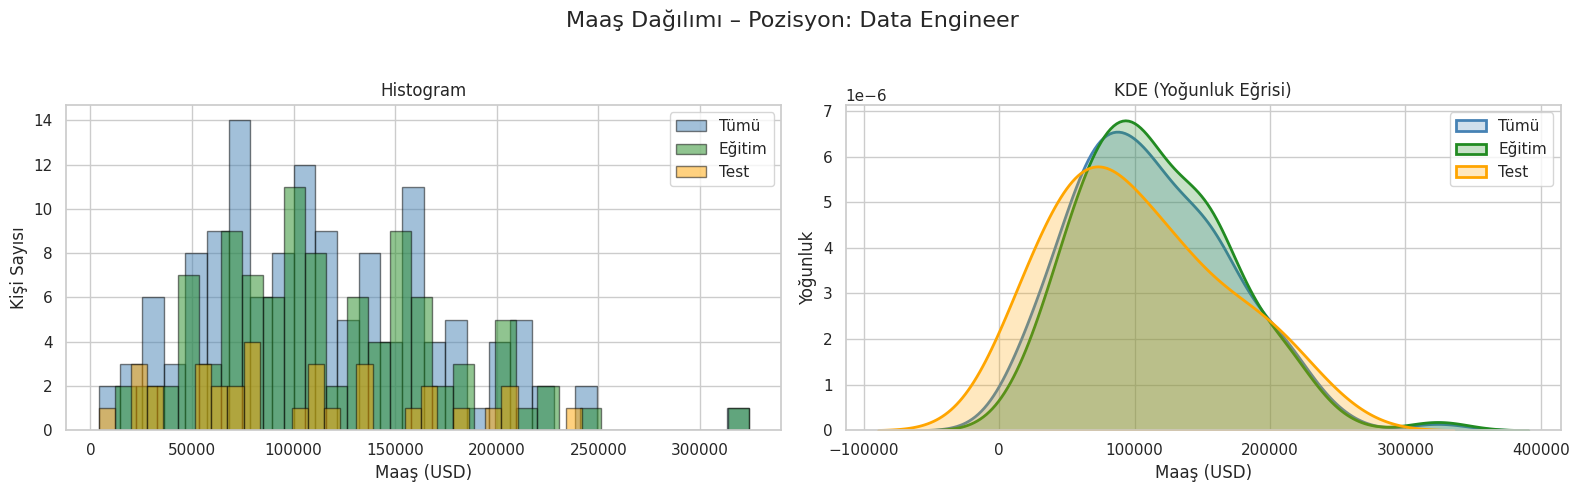

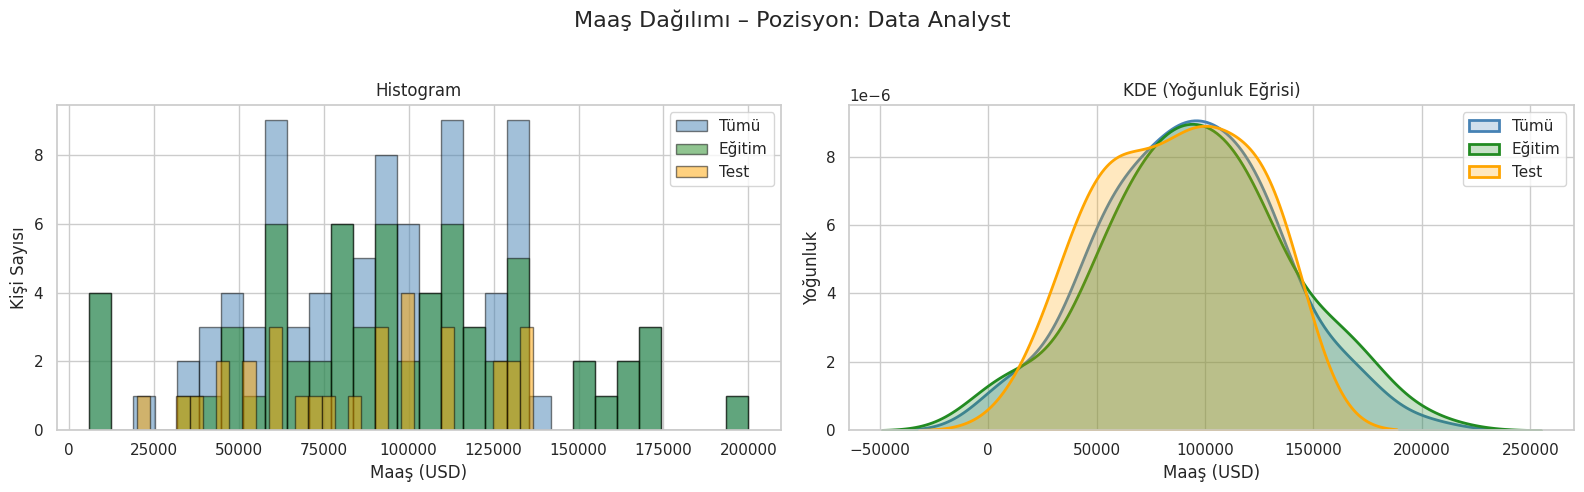

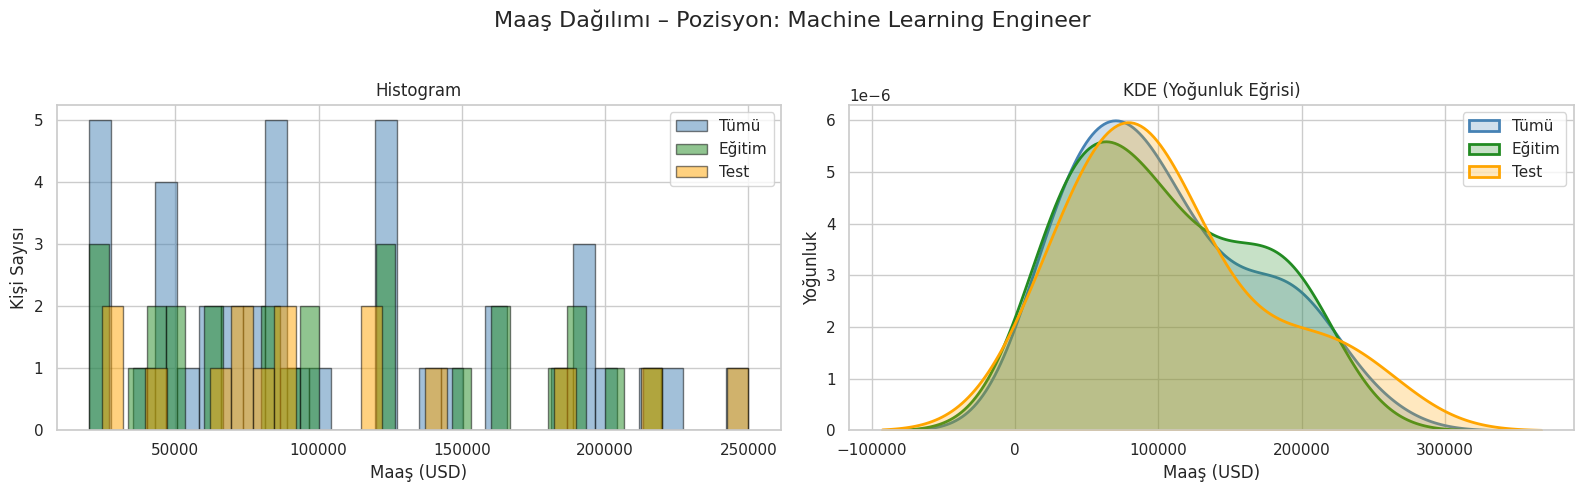

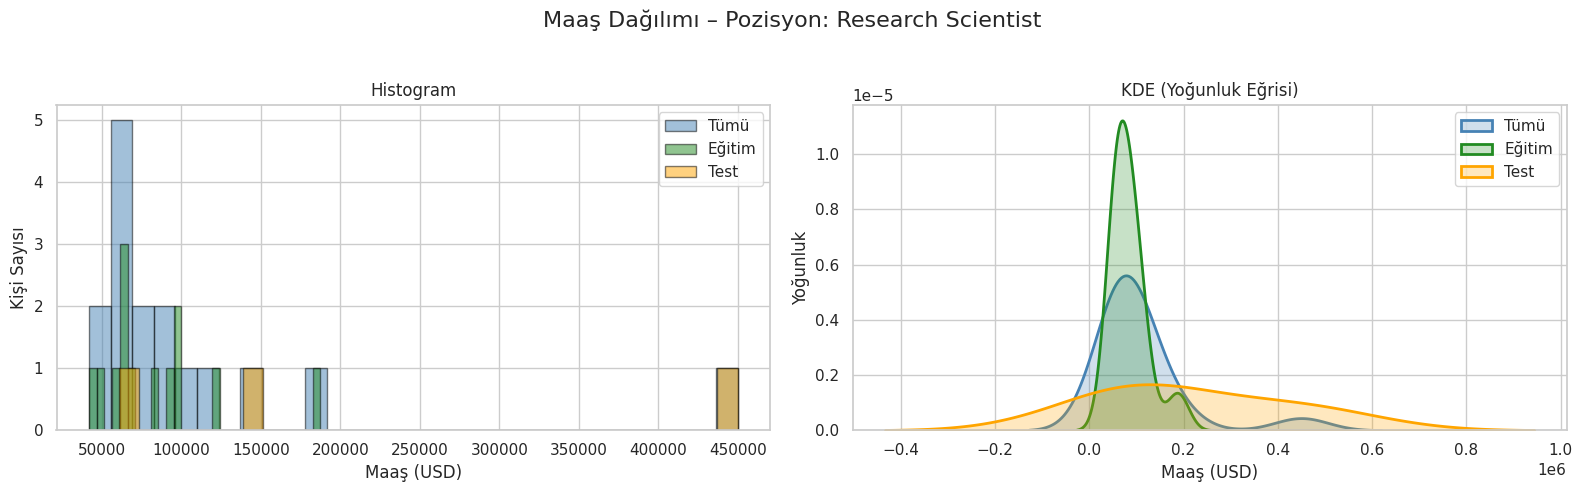

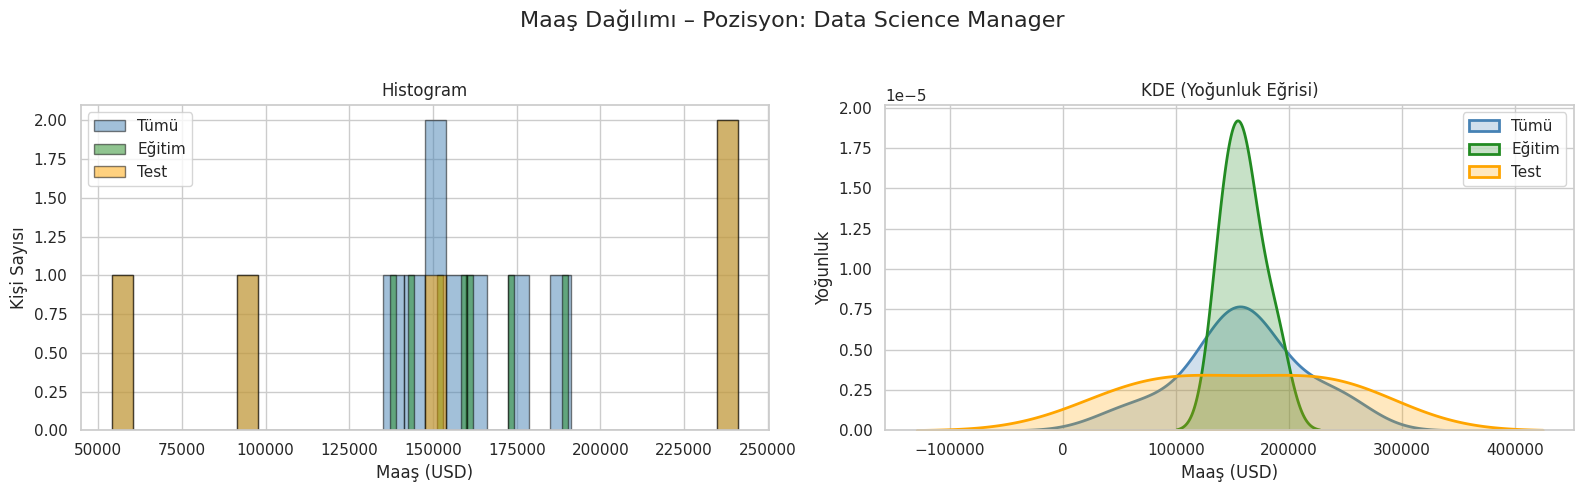

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Önce veri setinin tanımlı olduğundan emin ol
import pandas as pd

df_pd = df.select("Maas_USD", "Pozisyon", "Deneyim_Seviyesi").toPandas()
df_pd["Set"] = "Tümü"

train_pd = train_df.select("Maas_USD", "Pozisyon", "Deneyim_Seviyesi").toPandas()
train_pd["Set"] = "Eğitim"

test_pd = test_df.select("Maas_USD", "Pozisyon", "Deneyim_Seviyesi").toPandas()
test_pd["Set"] = "Test"

combined_df = pd.concat([df_pd, train_pd, test_pd], ignore_index=True)


renkler = {"Tümü": "steelblue", "Eğitim": "forestgreen", "Test": "orange"}

# En çok kayıt olan ilk 6 pozisyon için grafik çizme
pozisyonlar = combined_df["Pozisyon"].value_counts().head(6).index.tolist()

for poz in pozisyonlar:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f"Maaş Dağılımı – Pozisyon: {poz}", fontsize=16)

    # Histogram
    for set_tipi in ["Tümü", "Eğitim", "Test"]:
        alt_df = combined_df[(combined_df["Set"] == set_tipi) & (combined_df["Pozisyon"] == poz)]
        axes[0].hist(alt_df["Maas_USD"], bins=30, alpha=0.5, label=set_tipi,
                     color=renkler[set_tipi], edgecolor="black")
    axes[0].set_title("Histogram")
    axes[0].set_xlabel("Maaş (USD)")
    axes[0].set_ylabel("Kişi Sayısı")
    axes[0].legend()
    axes[0].grid(True)

    # KDE
    for set_tipi in ["Tümü", "Eğitim", "Test"]:
        alt_df = combined_df[(combined_df["Set"] == set_tipi) & (combined_df["Pozisyon"] == poz)]
        if not alt_df.empty:
            sns.kdeplot(alt_df["Maas_USD"], label=set_tipi, fill=True, ax=axes[1],
                        linewidth=2, color=renkler[set_tipi])
    axes[1].set_title("KDE (Yoğunluk Eğrisi)")
    axes[1].set_xlabel("Maaş (USD)")
    axes[1].set_ylabel("Yoğunluk")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
